# Introduction

The notebook is intended to provide an example on how to train a Recurrent Neural Network with TensorFlow on real sales data.

In [20]:
# Import Standard Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

2023-07-06 22:39:21.903355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read Data

In [7]:
# Read data through Pandas
data = pd.read_csv('./../../data/RSCCASN.csv', index_col='DATE', parse_dates=True)

In [10]:
# Rename columns
data.columns = ['Sales']

In [13]:
data

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


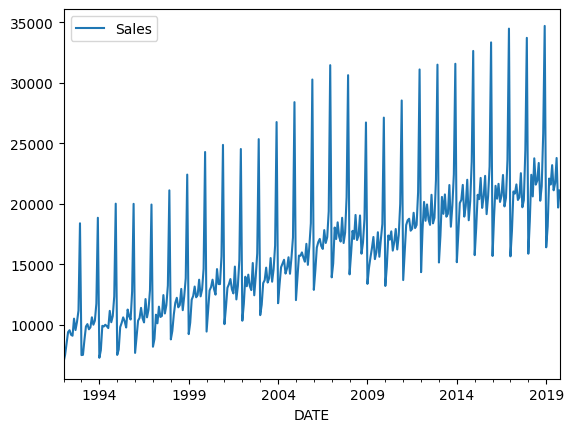

In [12]:
# Plot the data
data.plot()
plt.show()

# Train & Test Split

In [14]:
# Define test size in months
test_size = 18

In [15]:
# Split
train_data = data.iloc[:test_size]
test_data = data.iloc[test_size:]

# Data Preparation

## Standardization

In [17]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(train_data)

# Transform the data
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

## Batch Generator

In [18]:
# Define number of time steps in the input and the batch size
input_steps = 12
batch_size = 1

In [22]:
# Define the batch generator
batch_generator = TimeseriesGenerator(train_data_scaled,
                                      train_data_scaled,
                                      length=input_steps,
                                      batch_size=batch_size)